In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
from tensorboardX import SummaryWriter

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.distributions import Categorical

from torchvision import transforms

%matplotlib inline

In [2]:
env = gym.make("Pong-v0")

In [3]:
resize = transforms.Compose([transforms.ToPILImage(),transforms.Scale(size=40),transforms.ToTensor()])

def preprocess(obs):
    tensor = torch.from_numpy(obs.transpose((2, 0, 1)))
    resized = resize(tensor)
    return resized.unsqueeze(0)

def clip_grads(net, low=-10, high=10):
    """Gradient clipping to the range [low, high]."""
    parameters = [param for param in net.parameters()
                  if param.grad is not None]
    for p in parameters:
        p.grad.data.clamp_(low, high)
        
if torch.cuda.is_available():
    def to_var(x, requires_grad=False, gpu=None):
        x = x.cuda(gpu)
        return Variable(x, requires_grad=requires_grad)
else:
    def to_var(x, requires_grad=False, vgpu=None):
        return Variable(x, requires_grad=requires_grad)

In [4]:
class Net(nn.Module):
    def __init__(self, action_n):
        super().__init__()
        self.conv = nn.Sequential(nn.Conv2d(3,32,kernel_size=5),nn.ReLU(),nn.MaxPool2d(kernel_size=2),
                                  nn.Conv2d(32,128,kernel_size=5),nn.ReLU(),nn.MaxPool2d(kernel_size=2),
                                  nn.Conv2d(128,32,kernel_size=5),nn.ReLU(),nn.AdaptiveMaxPool2d(output_size=1))
        self.fc = nn.Linear(32, action_n)
        
    def forward(self, x):
        feat = self.conv(x)
        logit = self.fc(feat.view(feat.size(0),-1))
        return logit

In [5]:
class PolicyGradient:
    
    def __init__(self, model, gamma=0.99, eps=1.e-6, running_gamma=0.99, running_start=0,
#                 episode2thresh=lambda i: 0.05+0.9*np.exp(-1. * i / 100) if i>150 else 0): # eploration will start after 150 episodes
                 episode2thresh=lambda i: 0): # without exploration
        self.model = model
        self.gamma = gamma
        self.eps = eps
        self.log_probs = []
        self.rewards = []
        self.total_rewards = []
        self.running_reward = running_start
        self.running_gamma = running_gamma
        self.episode2thresh = episode2thresh
        
    @property
    def episodes(self):
        return len(self.total_rewards)
        
    def select_action(self,obs):
        self.model.train()
        thresh=self.episode2thresh(self.episodes)
        action, log_prob = select_action(obs, self.model, thresh=thresh)
        self.log_probs.append(log_prob)
        return action
    
    def get_loss_and_clear(self):
        total_reward = sum(self.rewards)
        self.total_rewards.append(total_reward)
        self.running_reward = self.running_gamma*self.running_reward+(1-self.running_gamma)*total_reward
        policy_loss = get_policy_loss(self.log_probs, self.rewards, self.gamma, self.eps)
        del self.log_probs[:]
        del self.rewards[:]
        return policy_loss
    
    def take_action(self, action, env, render=False):
        obs, reward, done, info = env.step(action)
        self.rewards.append(reward)
        if render:
            env.render()
        return obs, reward, done, info
    
    def greedy_policy(self, obs):
        self.model.eval()
        state = to_var(preprocess(obs))
        prob = self.model(state)
        _, action = prob.max(dim=1)
        return action.data[0]

def select_action(obs, model, thresh=0):
    state = to_var(preprocess(obs))
    logits = model(state)
    probs = F.softmax(logits, dim=1)
    m = Categorical(probs)
    if np.random.random()>thresh:
#         print(probs)
        try:
            action = m.sample()
        except:
            print(probs,m)
            raise
    else:
        action_space = probs.size(1)
        action = to_var(torch.from_numpy(np.random.randint(action_space,size=1)))
    return action.data[0],m.log_prob(action)
    
def get_normalized_rewards(rewards, gamma, eps):
    acc = []
    R = 0
    for r in reversed(rewards):
        R = r + gamma * R
        acc.append(R)
    ret = to_var(torch.Tensor(acc[::-1]),requires_grad=False)
    ret = (ret - ret.mean()) / (ret.std()+eps)
#     print(ret)
    return ret

def get_policy_loss(log_probs,rewards, gamma,eps):
    log_probs_v = torch.cat(log_probs)
    rewards_v = get_normalized_rewards(rewards, gamma, eps)
    return -log_probs_v.dot(rewards_v)

In [6]:
net = Net(env.action_space.n)
if torch.cuda.is_available():
    net = net.cuda()
optimizer = optim.Adam(net.parameters(), lr=3e-3,weight_decay=0.001)
trainer = PolicyGradient(model=net,running_start=-21)
writer = SummaryWriter()

In [7]:
for episode in range(20):
    last_frame = frame = env.reset()
    obs = frame-last_frame
    total_reward = 0
    for step in range(100000): # not exceed 10000 steps
        action = trainer.select_action(obs)
        frame, reward, done, _ = trainer.take_action(action, env, render=False)
        obs = frame-last_frame
        last_frame=frame
        total_reward+=reward
        if done:
             break
    if step==100000:
        print("not enough!!!!!!!!!!!!!!!")
    policy_loss = trainer.get_loss_and_clear()
    writer.add_scalar("loss",policy_loss.data[0],episode)
    writer.add_scalar("reward",total_reward,episode)
#     print(policy_loss)
    optimizer.zero_grad()
    policy_loss.backward()
    clip_grads(trainer.model,-5,5)
    optimizer.step()
    running_reward = trainer.running_reward
    print(episode, total_reward,running_reward)
    if running_reward>1:
        break
print("Finished: %s@%s" %(trainer.running_reward,episode))

0 -20.0 -20.99
1 -21.0 -20.990099999999998
2 -21.0 -20.990199
3 -20.0 -20.98029701
4 -20.0 -20.9704940399
5 -20.0 -20.960789099501
6 -20.0 -20.95118120850599
7 -20.0 -20.941669396420927
8 -21.0 -20.94225270245672
9 -20.0 -20.93283017543215
10 -20.0 -20.92350187367783
11 -21.0 -20.924266854941052
12 -21.0 -20.925024186391642
13 -20.0 -20.915773944527725
14 -20.0 -20.906616205082447
15 -19.0 -20.887550043031624
16 -21.0 -20.888674542601308
17 -20.0 -20.879787797175293
18 -21.0 -20.88098991920354
19 -21.0 -20.882180020011504
Finished: -20.882180020011504@19


In [8]:
torch.save(net.state_dict(), "pg.pth")

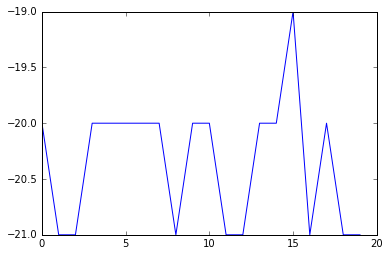

In [9]:
plt.plot(trainer.total_rewards)